In [1]:
pip install plotly


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Madrid Housing Data Analysis 2023
## Introduction

The project is an analysis of housing prices of Madrid, Spain. 

The first part of the project is to scope, prepare, analyze and visualise data to explain what affects real estate (asking) prices. 

The second part of the project focuses on price predictions using machine learning models. 
## Project Scope
### Goals
The main goal of the project is whether it can be determined that a property is overpriced or not based on its parameters, therefore deciding if it is a good fit for potential acquisition.  
Some further questions the project seeks to answer:
- Does location affect the price? 
- Are flats with parking space more expensive? 
- Does having an elevator increase the price? 
- What's the size of flats? 

### Data Source: ###

Data was downloaded manually from idealista.com, the largest Spanish real estate website. To reduce time, only 2111 .html sites were downloaded and used out of the 21487 in the city, particularly from Usera, Arganzuela and Retiro districts.

### Preparation ###

.html documents were converted in `madrid_housing_data_import.ipynb` by using BeautifulSoup library to create a tabular `madrid_housing_data.csv` that is easier to use. 

### Data Quality ###
Most of the data was in text format that resembled JSON and the rest of the text was scraped with regular expressions. The data is a glimpse of a fraction of the market, but adequate for exploratory data anaylsis and ML model building. 


Disclaimer: The analysis serves only educational purposes. 

In [2]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from IPython.display import clear_output

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import get_scorer_names
import xgboost as xgb
import pickle
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('madrid_housing_data.csv') # The CSV contains the following information:
useful_cols = [
    'ad.id', # identification number of the ad       
    'ad.builtType', # type of the building 
    'ad.address.locationId', # location of the building
    'ad.energyCertification.type', # energy consumption certificate and below its suffix
    'ad.energyCertification.suffix', 
    'ad.price', # asking price
    'ad.characteristics.roomNumber', # number of rooms 
    'ad.characteristics.bathNumber', # number of bathrooms
    'ad.characteristics.hasLift', # boolean, the building has elevator or not
    'ad.characteristics.constructedArea', # total area of the flat
    'ad.condition.isNewDevelopment', # condition_1 : new flat
    'ad.condition.isNeedsRenovating', # condition_2 : needs renovation
    'ad.condition.isGoodCondition', # condition_3 : the flat is not new, but needs renovation
    'ad.owner.type', # type of the owner
    'ad.isSuitableForRecommended', # unknown
    'ad.numberRecommended', # unknown
    'longitude', # geolocation, coordinates
    'latitude', # geolocation, coordinates
    'distrito', # district (larger unit of area)
    'barrio', # neighborhood (smaller unit of area)
    'planta', # level
    'garaje', # Includes a garage or not or if it is an optional buy
    'garaje_coste', # the cost of the optional garage
    'int_ext', # whether the flat is interior or exterior
]

df = df[useful_cols]
df['garaje_coste'] = df['garaje_coste'].astype('float')
df['price_per_sqm'] = df['ad.price']/df['ad.characteristics.constructedArea'] # create unit price as new feature

In [4]:
df.rename(columns = {
    'ad.id':'id', 
    'ad.builtType':'built_type', 
    'ad.address.locationId':'locationId',
    'ad.energyCertification.type':'energy_cert_type',
    'ad.energyCertification.suffix':'energy_cert_suffix',
    'ad.price':'price',
    'ad.characteristics.roomNumber':'room_number',
    'ad.characteristics.bathNumber':'bath_number',
    'ad.characteristics.hasLift':'has_lift',
    'ad.characteristics.constructedArea':'area',
    'ad.condition.isNewDevelopment':'cond_new_dev',
    'ad.condition.isNeedsRenovating':'cond_needs_renovation',
    'ad.condition.isGoodCondition':'cond_good',
    'ad.owner.type':'owner_type',
    'ad.isSuitableForRecommended':'suitable_for_recommended',
    'ad.numberRecommended':'number_recommended',
    }, inplace = True)

df['distrito'].fillna('unknown', inplace=True) #filling unknown areas
df['barrio'].fillna('unknown', inplace=True) #filling unknown areas


The dataset is almost complete, only number_recommended and energy_cert_suffix columns have high number of unknown values. District and Neighborhood data has missing values that will be identified at a later step

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2111 non-null   int64  
 1   built_type                2111 non-null   int64  
 2   locationId                2111 non-null   object 
 3   energy_cert_type          2111 non-null   object 
 4   energy_cert_suffix        249 non-null    object 
 5   price                     2111 non-null   float64
 6   room_number               2111 non-null   float64
 7   bath_number               2111 non-null   float64
 8   has_lift                  2111 non-null   int64  
 9   area                      2111 non-null   float64
 10  cond_new_dev              2111 non-null   int64  
 11  cond_needs_renovation     2111 non-null   int64  
 12  cond_good                 2111 non-null   int64  
 13  owner_type                2111 non-null   int64  
 14  suitable

## Data Analysis 

### Location, Location, Location - Map Analysis
The below map shows the area covered by the dataset. 
Green color indicates that properties outside of the M30 motorway (in the Usera neighborhood) are the cheapest and flats around the park in Retiro are the most expensive.
Properties in Arganzuela neighborhood are in between. 

In [6]:
# 'https://levelup.gitconnected.com/visualizing-housing-data-with-folium-maps-4718ed3452c2'
import folium
import branca.colormap as cm

min_price = df['price_per_sqm'].min()
max_price = df['price_per_sqm'].max()
df.sort_values(by='price_per_sqm', axis=0, ascending=True, inplace=True) #so that more expensive flats come out on top of the map
colormap = cm.LinearColormap(colors=['green', 'yellow', 'orange', 'red'], vmin=min_price, vmax=12000) 
#LinearColormap so we can see a continuous set of colors
#We set maximum price to 12.000 EUR/sqm, because there are a few outliers that would otherwise skew the map. 
map_obj = folium.Map(location = [40.39815678628541, -3.6999939728202333], zoom_start = 12)


for i in range(len(df)):
    folium.Circle(
        location=[df.iloc[i]['latitude'], df.iloc[i]['longitude']],
        radius=80,
        fill=True,
        color=colormap(df.iloc[i]['price_per_sqm']),
        tooltip=round(df.iloc[i]['price_per_sqm']),
        fill_opacity=0.85).add_to(map_obj)

colormap.caption = 'Home prices, EUR/m2'
map_obj.add_child(colormap)
map_obj
# map might be unavailable on github preview. Solution with nbviewer: https://nbviewer.orgithub/gorogandras/madrid_housing_data_analysis/blob/main/madrid_housing_data_analysis.ipynb

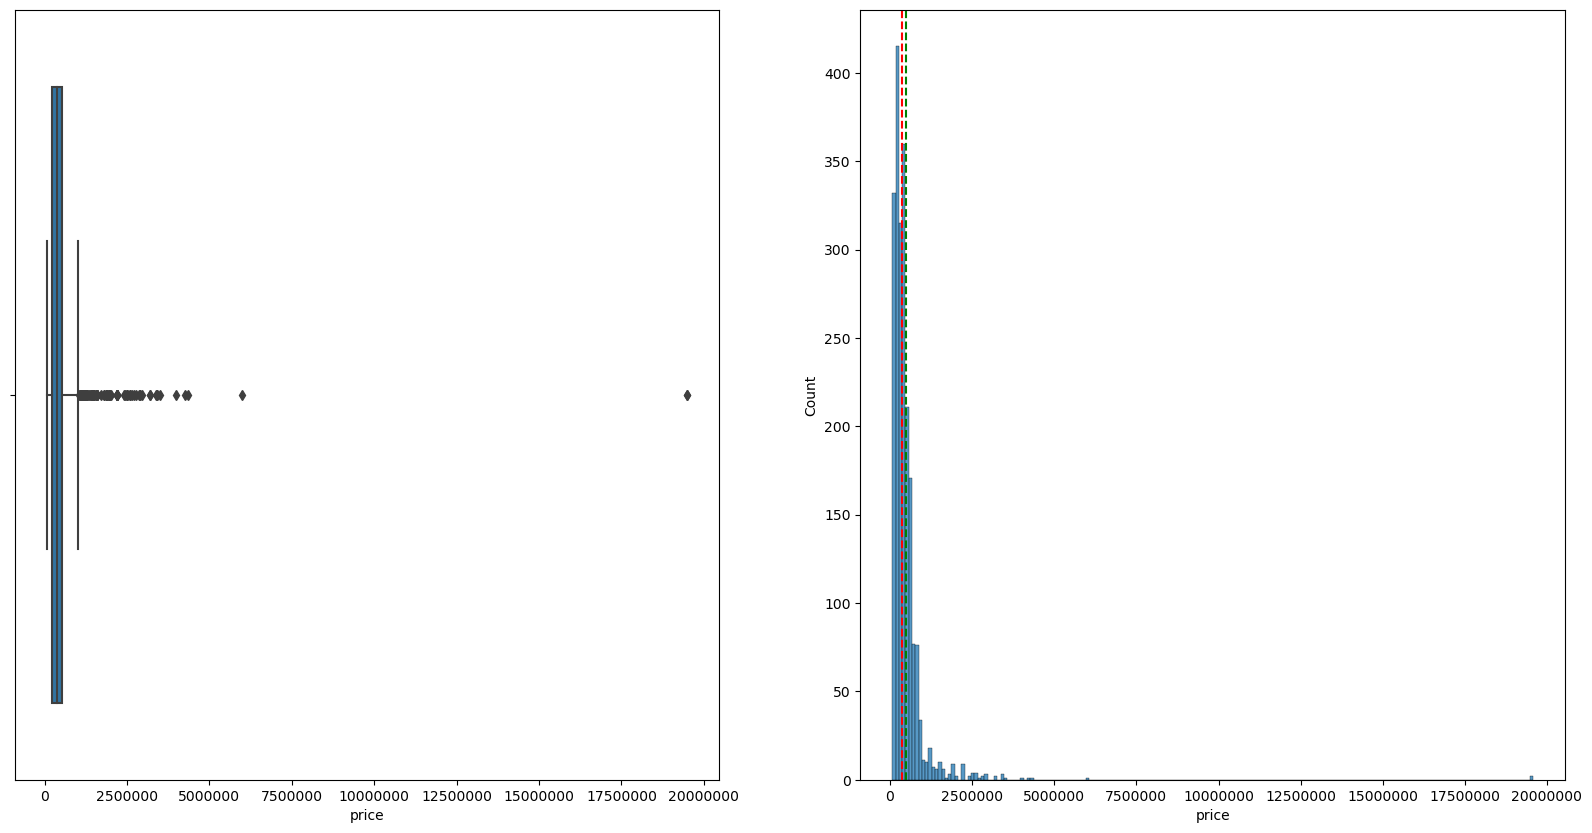

<Figure size 640x480 with 0 Axes>

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
sns.boxplot(x='price', data=df, ax=axs[0])
axs[0].ticklabel_format(style='plain', axis='x')
sns.histplot(x='price', data=df, ax=axs[1], binwidth = 100000)
plt.ticklabel_format(style='plain', axis='x')
axs[1].axvline(df["price"].median(), color='r', linestyle='--')
axs[1].axvline(df["price"].mean(), color='g', linestyle='--')
plt.show()
plt.clf()

In [8]:
print(f'The dataframe is highly skewed to the right as its skewness is {round(df.price.skew())}')
print('If only keep data that is below 10.000.000 EUR we only have to exclude two data points that belong to the same luxury flat')
df_topcut = df[df['price']<10000000] 
print(f'The new skewness is {round(df_topcut.price.skew())}, which is much better but still quite high.')

The dataframe is highly skewed to the right as its skewness is 18
If only keep data that is below 10.000.000 EUR we only have to exclude two data points that belong to the same luxury flat
The new skewness is 4, which is much better but still quite high.


In [9]:
min_price = round(df.price.min())
max_price = round(df.price.max())
len_99_9 = round(df['price'].quantile(q=0.999))
len_99 = round(df['price'].quantile(q=0.99))
len_95 = round(df['price'].quantile(q=0.95))
print(f"""
    min_price: {min_price}
    max price: {max_price}
    99.9% of flats are blow price: {len_99_9}
    99% of flats are blow price: {len_99}
    95% of flats are blow price: {len_95}
    """)



    min_price: 69900
    max price: 19500000
    99.9% of flats are blow price: 5818500
    99% of flats are blow price: 2581000
    95% of flats are blow price: 1097500
    


Since the prices are highly skewed, the top 5% will be ignored during prediction. This still leaves enough data but improves the prediction.
As seen below, there is no outlier in observations based on the area, all three districts are represented in the dataset, with Arganzuela being the majority (830) and Usera being the minority (543). 

In [10]:
df['distrito'].value_counts()

Arganzuela    830
Retiro        730
Usera         543
unknown         8
Name: distrito, dtype: int64

### Correlation between features: Contingency Table, collinearity 

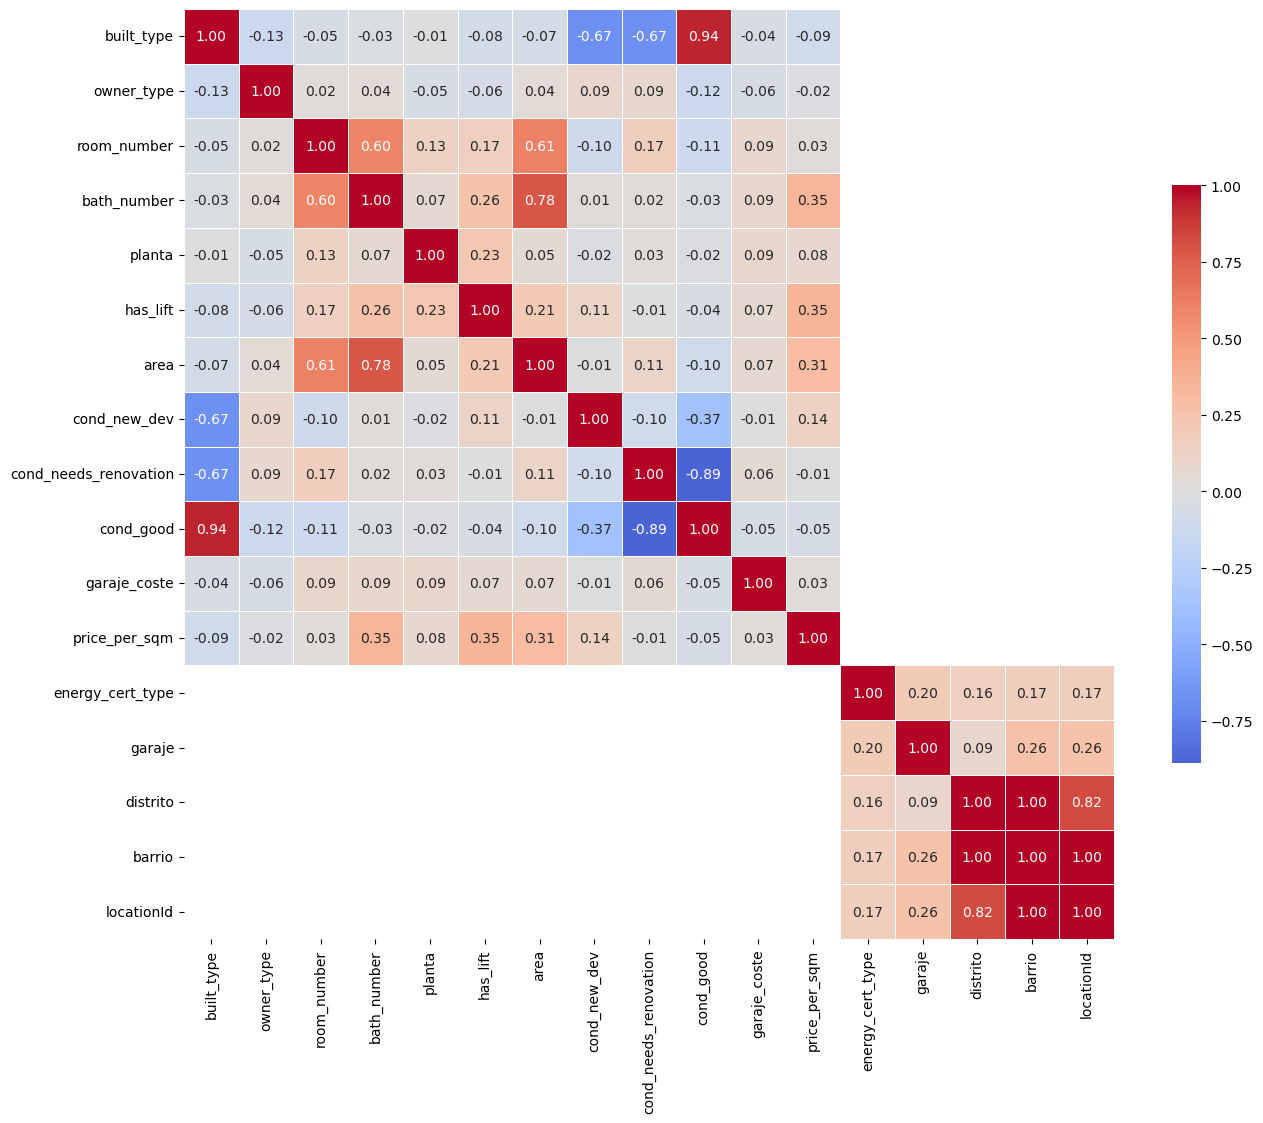

<function matplotlib.pyplot.clf()>

In [11]:
from scipy.stats import chi2_contingency

df_corr = df[['built_type','energy_cert_type', 'garaje', 
        'owner_type', 'distrito', 'barrio', 'room_number', 'bath_number', 'planta', 
        'has_lift', 'area','cond_new_dev', 'cond_needs_renovation', 'cond_good', 'garaje_coste', 'price_per_sqm', 'locationId']]

# Compute the correlation matrix for numerical data
corr_num = df_corr.select_dtypes(include=['float64', 'int64']).corr()

# Compute the Cramer's V statistic for categorical data
corr_cat = pd.DataFrame(np.zeros((len(df_corr.select_dtypes(include=['object']).columns), 
                                   len(df_corr.select_dtypes(include=['object']).columns))), 
                         columns=df_corr.select_dtypes(include=['object']).columns, 
                         index=df_corr.select_dtypes(include=['object']).columns)

for i, var1 in enumerate(df_corr.select_dtypes(include=['object']).columns):
    for j, var2 in enumerate(df_corr.select_dtypes(include=['object']).columns):
        if i == j:
            corr_cat.loc[var1, var2] = 1
        else:
            confusion_matrix = pd.crosstab(df_corr[var1], df_corr[var2])
            chi2, _, _, _ = chi2_contingency(confusion_matrix)
            n = confusion_matrix.sum().sum()
            corr_cat.loc[var1, var2] = np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

# Combine the correlation matrices for numerical and categorical data
corr = pd.concat([corr_num, corr_cat], axis=1)
#corr = pd.concat([corr, pd.concat([corr_cat.T, pd.DataFrame(np.zeros((len(df.select_dtypes(include=['object']).columns), 
#                                                                         len(df.select_dtypes(include=['object']).columns))))], axis=1)], axis=0)

# Generate a mask for the upper triangle
#mask = np.zeros_like(corr, dtype=bool)
#mask[np.triu_indices_from(mask)] = True

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, 
            #mask=mask, 
            cmap='coolwarm', annot=True, fmt='.2f', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
plt.clf


- Room number and bath number have high correlation with area. 
- 1:1 correlation between distrito and barrio. We must only use one of them at prediction to avoid multicollinearity.  
- conditon_good and condition_needs_renovation, as expected, are highly correlated as well, therefore one of them must be deleted.  
- built_type is is highly correlated with these variables. Let's further investigate this at condition
- Relationship between locationId and distrito/barrio must be analyzed in detail.

### distrito and barrio

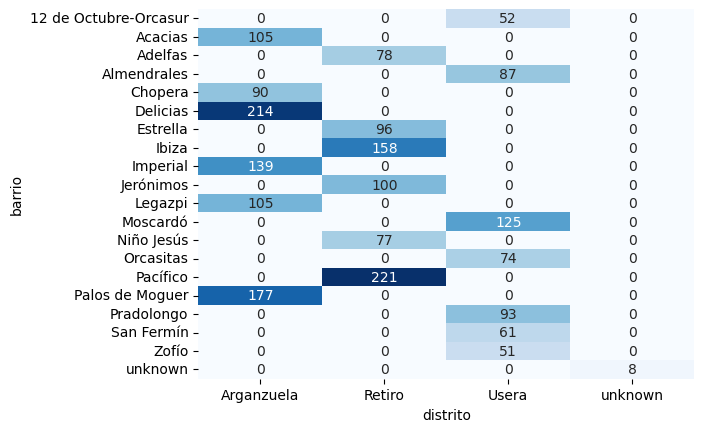

<Figure size 640x480 with 0 Axes>

In [12]:
sns.heatmap(pd.crosstab(df.barrio, df.distrito),
            cmap="Blues", annot=True, cbar=False, fmt='d')
plt.show()
plt.clf()

- With the crosstab it is clear that barrios (neighborhoods) belong to distritos (districts)
- All barrios are represented in the dataset with different ratios, Delicias being the highest (214 entries) and Zofío being the lowest (51 entries). 
- Only 8 flats with unknown distrito/barrio (the same ones).
- Even though nor 'barrio', nor 'distrito', nor coordinates were put in the dataset, the below table shows that the location code gives away the neighborhood of the property.
- This means the data can be saved, the corresponding 'barrio' and 'distrito' will be inputed. 

In [13]:
df['loc_code'] = df['locationId'].str.replace('-', '').str[-5:] #Creation of loc_code feature that is the last 5 digits of locationId. 

# create a dictionary to map known locationIds to their corresponding barrios and distritos
loc_to_barrio = dict(df[df.barrio != 'unknown'][['locationId', 'barrio']].values)
loc_to_dist = dict(df[df.distrito != 'unknown'][['locationId', 'distrito']].values)
# create a mask to identify unknown locations
unknown_mask_barrio = df.barrio == 'unknown'
unknown_mask_distrito = df.distrito == 'unknown'
 # fill the unknown locations with their corresponding neighborhoods from the dictionary
df.loc[unknown_mask_barrio, 'barrio'] = df[unknown_mask_barrio]['locationId'].map(loc_to_barrio)
df.loc[unknown_mask_distrito, 'distrito'] = df[unknown_mask_distrito]['locationId'].map(loc_to_dist)

<Axes: xlabel='barrio', ylabel='loc_code'>

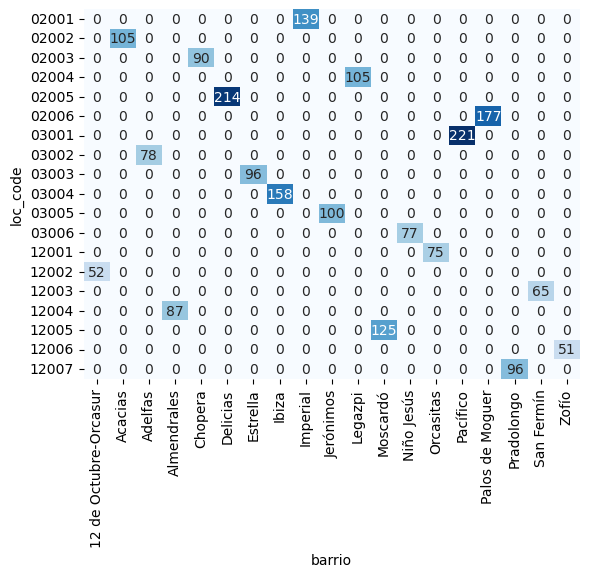

In [14]:
sns.heatmap(pd.crosstab(df['loc_code'], df['barrio']),
            cmap="Blues", annot=True, cbar=False, fmt='d')

In [15]:
df['barrio'].value_counts()

Pacífico                 221
Delicias                 214
Palos de Moguer          177
Ibiza                    158
Imperial                 139
Moscardó                 125
Acacias                  105
Legazpi                  105
Jerónimos                100
Pradolongo                96
Estrella                  96
Chopera                   90
Almendrales               87
Adelfas                   78
Niño Jesús                77
Orcasitas                 75
San Fermín                65
12 de Octubre-Orcasur     52
Zofío                     51
Name: barrio, dtype: int64

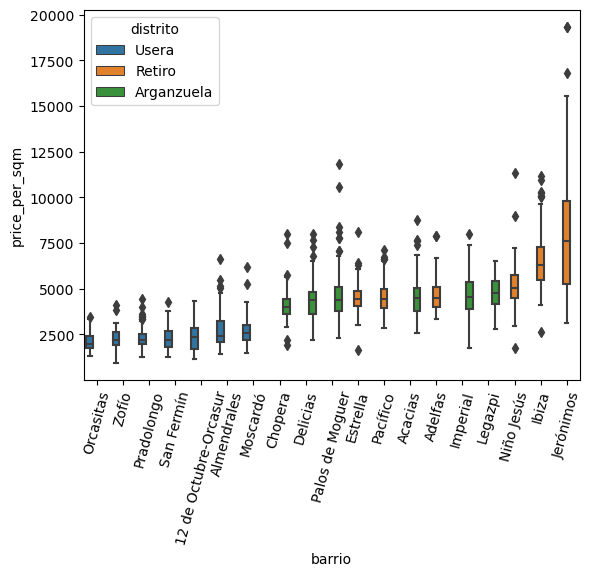

<Figure size 640x480 with 0 Axes>

In [16]:
grouped = df.loc[:,['barrio', 'price_per_sqm']] \
    .groupby(['barrio']) \
    .median() \
    .sort_values(by='price_per_sqm')

sns.boxplot(x=df.barrio, 
            y=df.price_per_sqm,
            hue= df.distrito, 
            order=grouped.index)
plt.xticks(rotation=75)
plt.show()
plt.clf()

In [17]:
grouped

,price_per_sqm
barrio,
Orcasitas,1962.962963
Zofío,2171.052632
Pradolongo,2172.998643
San Fermín,2173.913043
12 de Octubre-Orcasur,2343.792982
Almendrales,2405.063291
Moscardó,2560.975610
Chopera,4011.926972
Delicias,4360.400000


### Location vs size
Properties in Retiro, the affluent district of the three are 36% larger than in the other two districts, taking into account the median.

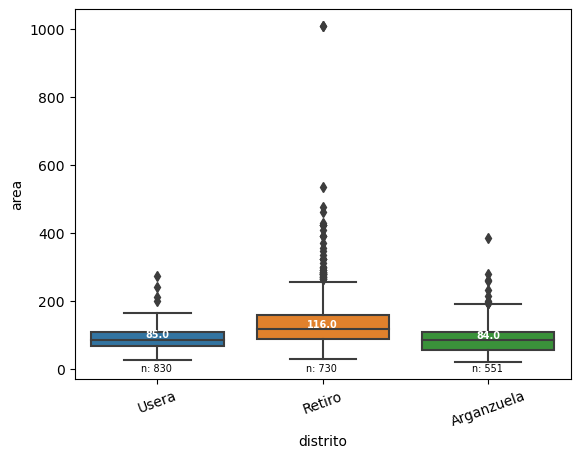

<Figure size 640x480 with 0 Axes>

In [18]:
df_area = df.copy()

medians = df_area.groupby('distrito')['area'].median().round(decimals=0)
nobs = df_area.groupby('distrito')['area'].count()

boxplot = sns.boxplot(data=df_area, x="distrito", y="area",
                      )

vertical_offset = df['area'].median() * (+0.07) # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    boxplot.text(xtick-0.1,-vertical_offset,'n: '+str(nobs[xtick]), size='x-small')
plt.xticks(rotation=20)
plt.show()
plt.clf()

In [19]:
df_area.loc[:,['distrito', 'area']] \
    .groupby(['distrito']).agg({'area': ['median', 'min', 'max']})

area              
           median   min     max
distrito                       
Arganzuela   85.0  20.0   384.0
Retiro      115.5  30.0  1008.0
Usera        84.0  27.0   274.0

Distribution of flat sizes

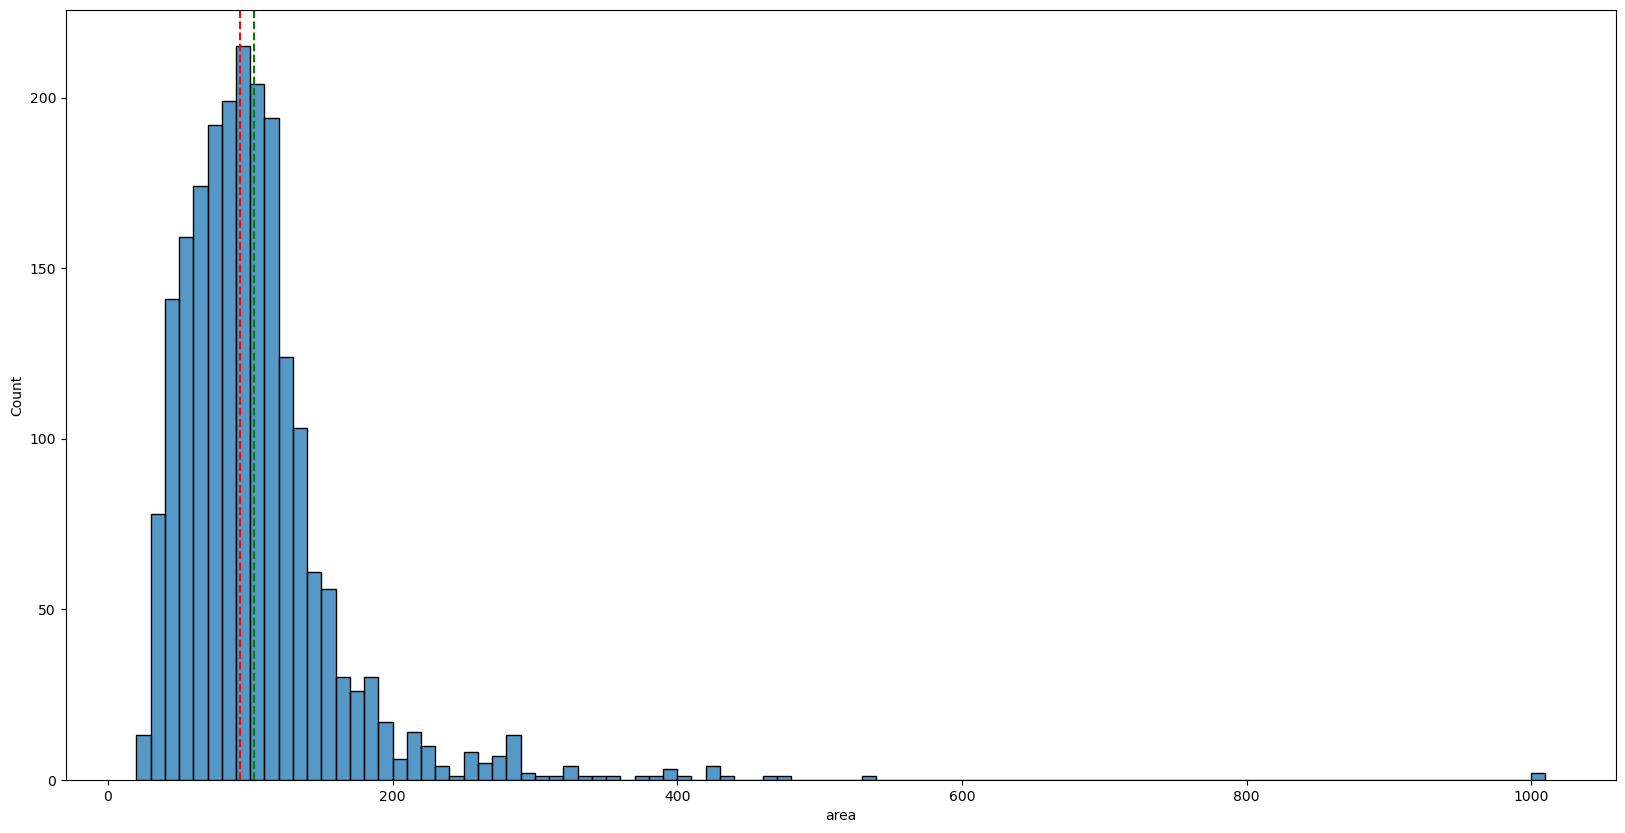

In [20]:
fig, axs = plt.subplots(ncols=1, figsize=(20,10))
sns.histplot(x='area', data=df, ax=axs, binwidth = 10)
plt.ticklabel_format(style='plain', axis='x')
axs.axvline(df["area"].median(), color='r', linestyle='--')
axs.axvline(df["area"].mean(), color='g', linestyle='--')

In [21]:
flatsize_median =round(df["area"].median())
flatsize_mean = round(df["area"].mean())
print(f'The size distribution is slightly skewed to the right as its skewness is {round(df.area.skew())}')
print("The median flat size is {} sqm, the average flat size is {} sqm".format(flatsize_median, flatsize_mean))

The size distribution is slightly skewed to the right as its skewness is 5
The median flat size is 93 sqm, the average flat size is 103 sqm


### room_number
The vast majority of properties (66%) have 2 or 3 rooms. Up to 4 rooms it can be clearly seen that the increase of room number slightly decreases the median asking price

In [22]:
df['room_number'].value_counts()

3.0     786
2.0     608
1.0     301
4.0     291
5.0      72
0.0      33
6.0      13
11.0      3
7.0       2
12.0      1
8.0       1
Name: room_number, dtype: int64

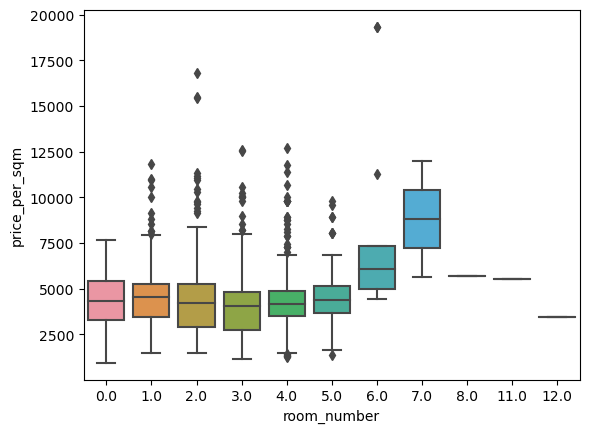

<Figure size 640x480 with 0 Axes>

In [23]:
sns.boxplot(data=df, x="room_number", y="price_per_sqm")
plt.show()
plt.clf()

### bath_number

In [24]:
df['bath_number'].value_counts()

1.0     967
2.0     952
3.0     143
4.0      23
5.0      13
6.0       7
0.0       4
9.0       1
10.0      1
Name: bath_number, dtype: int64

### built_type
Built type can influence the cost, but the relationship is not linear. 
Type 1 seems to be the most expensive and type 2 the least expensive, therefore we are going to use One Hot Encoding. 

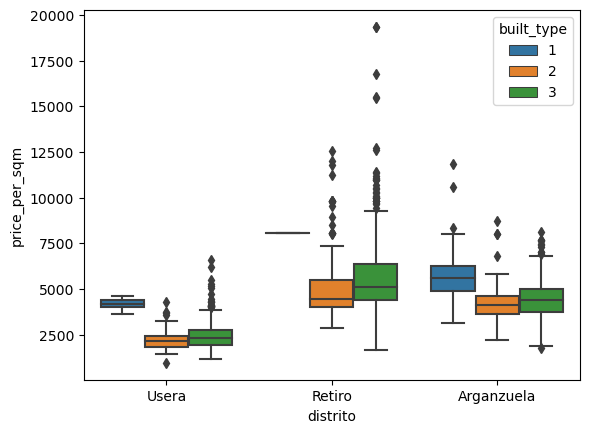

<Figure size 640x480 with 0 Axes>

In [25]:
sns.boxplot(data=df, x="distrito", y="price_per_sqm", hue='built_type')
plt.show()
plt.clf()

df['built_type'].value_counts()

df['built_type'] = df['built_type'].astype('str')
# 

### energy_cert_type, energy_cert_suffix
Most properties have no valid energy certificate uploaded. Where it is indicated, a clear correlation can be seen with the price, energy-efficient homes being the more expensive ones. 

In [26]:
df['energy_cert_suffix'].value_counts() # energy_cert_suffix has no influence

spainDefault    249
Name: energy_cert_suffix, dtype: int64

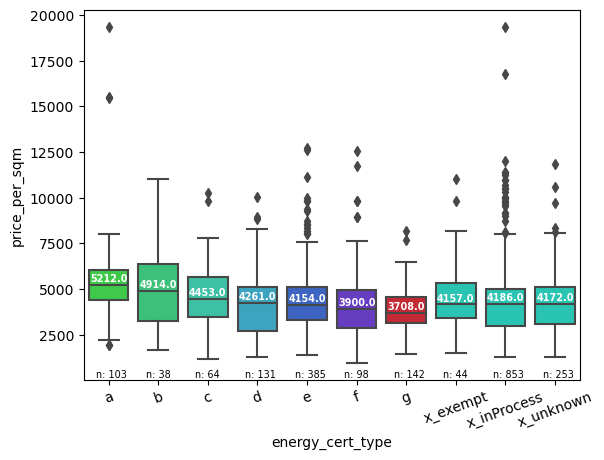

<Figure size 640x480 with 0 Axes>

In [27]:
df_energy = df.copy()
df_energy['energy_cert_type'].replace({'inProcess':'x_inProcess', 
                                       'exempt':'x_exempt', 
                                       'unknown':'x_unknown'}, inplace=True)
order = sorted(df_energy.energy_cert_type.unique())
my_pal = {"a": "#28e038", 
          "b": "#27d679", 
          "c": "#27d6b0", 
          "d": "#27b0d6",
          "e": "#275bd6",
          "f": "#5e27d6",
          "g": "#de1021",
          "x_inProcess":"#10dec6",
          "x_exempt": "#10dec6",
          "x_unknown": "#10dec6"}
medians = df_energy.groupby('energy_cert_type')['price_per_sqm'].median().round(decimals=0)
nobs = df_energy.groupby('energy_cert_type')['price_per_sqm'].count()

boxplot = sns.boxplot(data=df_energy, x="energy_cert_type", y="price_per_sqm", order=order, palette=my_pal)

vertical_offset = df['price_per_sqm'].median() * 0.04 # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    boxplot.text(xtick-0.25,vertical_offset,'n: '+str(nobs[xtick]), size='x-small')
plt.xticks(rotation=20)
plt.show()
plt.clf()

In [28]:
df_energy.groupby('energy_cert_type')['price_per_sqm'].count()


energy_cert_type
a              103
b               38
c               64
d              131
e              385
f               98
g              142
x_exempt        44
x_inProcess    853
x_unknown      253
Name: price_per_sqm, dtype: int64

### exterior or interior
Correlation is unclear. It is important to note that this data was scraped from the text of the ad. "both" entries are where both words appeared in the .html. 

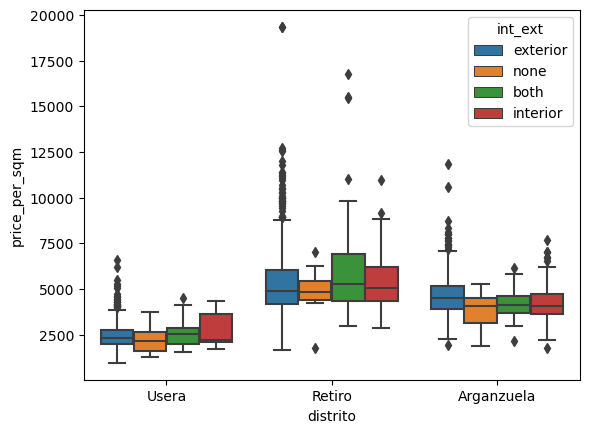

<Figure size 640x480 with 0 Axes>

In [29]:
df['int_ext'].value_counts().values

sns.boxplot(data=df, x="distrito", y="price_per_sqm", hue='int_ext')
plt.show()
plt.clf()

### has_lift
Properties in buildings with elevators (1635) are 78% more expensive than in buildings without them (476). 

In [30]:
df['has_lift'].value_counts()

1    1635
0     476
Name: has_lift, dtype: int64

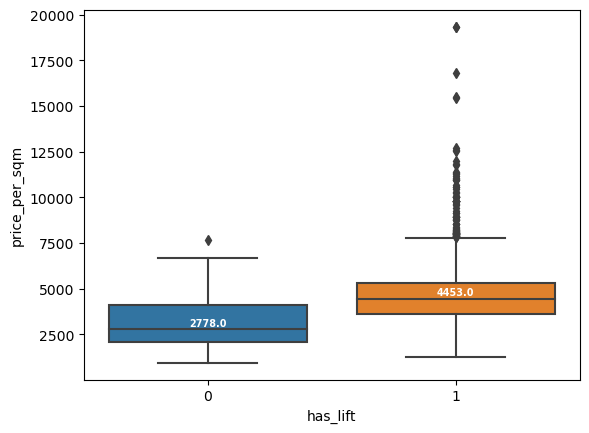

<Figure size 640x480 with 0 Axes>

In [31]:
boxplot = sns.boxplot(data=df, x='has_lift', y="price_per_sqm")
medians = df.groupby('has_lift')['price_per_sqm'].median().round(decimals=0)
vertical_offset = df['price_per_sqm'].median() * 0.04 # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    
plt.show()
plt.clf()

### condition
Based on the heatmap below buit_type and condition is one and the same, only one of them must be used in predictions. 
New developments cost most money while flats in good condition are only slightly more expensive than ones waiting to be renovated. This can be an important factor while purchasing as renovation prices tend to be costly and time consuming. 

In [32]:
df_condition = df.copy()
# we create a single column for conditions
df_condition['condition']='' # to create an empty column

for col_name in df_condition[['cond_new_dev', 'cond_needs_renovation', 'cond_good', 'price_per_sqm']]:
    df_condition.loc[df_condition[col_name]==1,'condition']= df_condition['condition']+' '+col_name

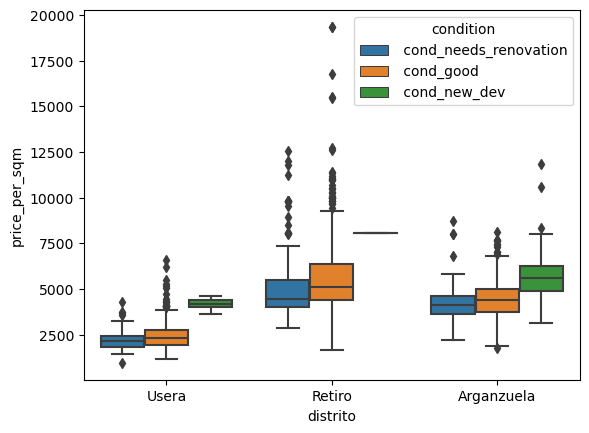

<Figure size 640x480 with 0 Axes>

In [33]:
boxplot = sns.boxplot(data=df_condition, x='distrito', y="price_per_sqm", hue='condition')

plt.show()
plt.clf()
#

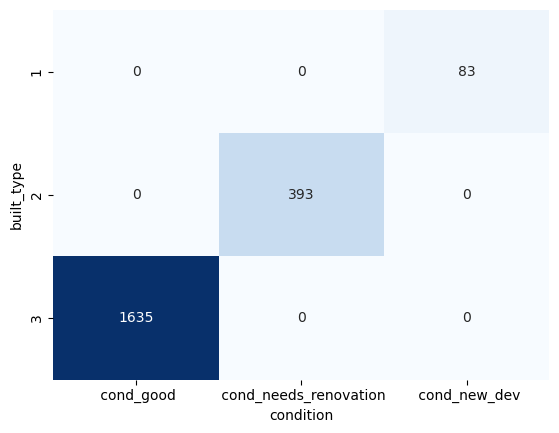

<Figure size 640x480 with 0 Axes>

In [34]:
sns.heatmap(pd.crosstab(df_condition.built_type, df_condition.condition),
            cmap="Blues", annot=True, cbar=False, fmt='d')
plt.show()
plt.clf()

### planta
Up until the 8th level median prices tend to go up. It could be interesting to see which ones are top floor properties. 

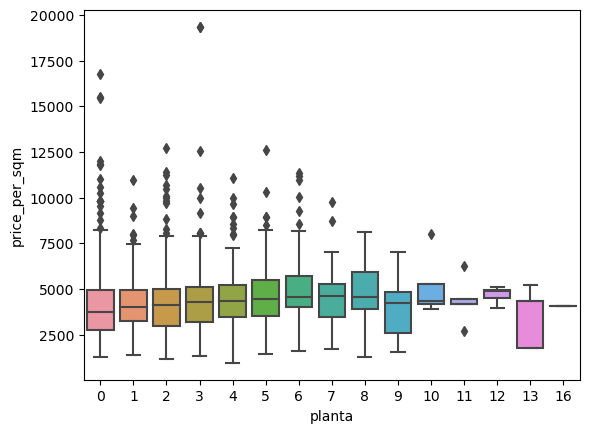

<Figure size 640x480 with 0 Axes>

In [35]:
boxplot = sns.boxplot(data=df, x='planta', y="price_per_sqm")
plt.show()
plt.clf()

### garaje
24% of properties have optional or included garages. These ones are 50-60% more expensive. 

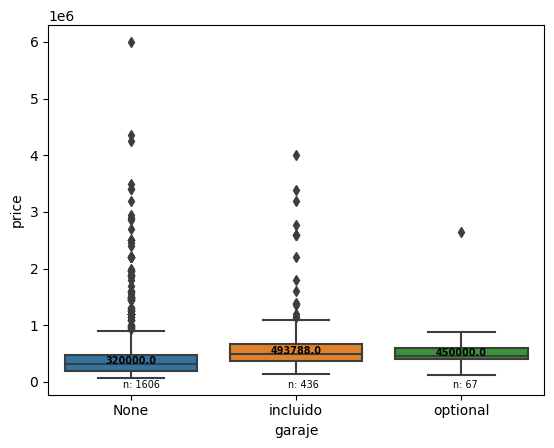

<Figure size 640x480 with 0 Axes>

In [36]:
df['garaje'].replace({'Garaje incluido':'incluido'}, inplace=True)

df_garaje = df.copy()
df_garaje = df_garaje[df_garaje.price<10000000] # The most expensive property excluded for bettwer visualisation
boxplot = sns.boxplot(data=df_garaje, x='garaje', y="price")
medians = df_garaje.groupby('garaje')['price'].median().round(decimals=0)#.sort_values(ascending=True)
nobs = df_garaje['garaje'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

vertical_offset = df_garaje['price'].median() * 0.3 # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick],medians[xtick],
            horizontalalignment='center',size='x-small',color='#000000',weight='semibold')
    boxplot.text(xtick-0.05,-vertical_offset,nobs[xtick], size='x-small', color='#000000')

plt.show()
plt.clf()

### owner_type
The difference between the two types of this variable could not be identified. 

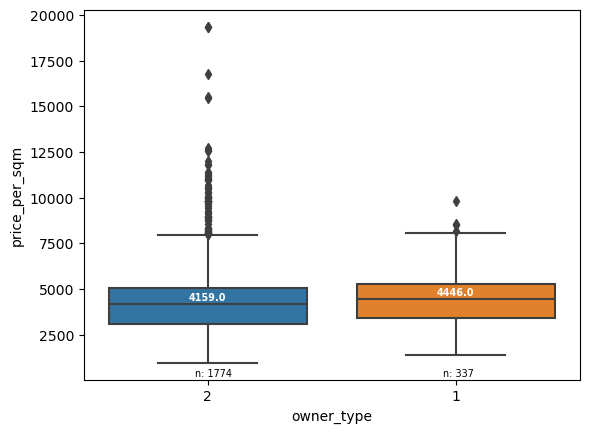

<Figure size 640x480 with 0 Axes>

In [37]:
df['owner_type'] = df['owner_type'].astype('str')
boxplot = sns.boxplot(data=df, x='owner_type', y="price_per_sqm")
medians = df.groupby('owner_type')['price_per_sqm'].median().round(decimals=0).sort_values(ascending=True)
nobs = df['owner_type'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

vertical_offset = df['price_per_sqm'].median() * 0.05 # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    boxplot.text(xtick-0.05,vertical_offset,nobs[xtick], size='x-small')

plt.show()
plt.clf()

### suitable_for_recommended
Price per SQM seems to be highly correlated to sutiable_for_recommended, although this variable could not be identified. 

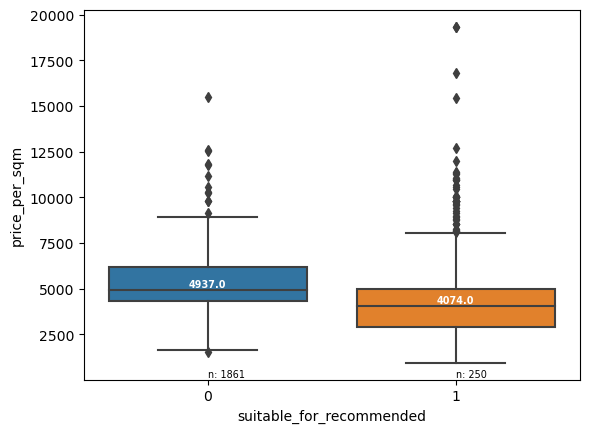

<Figure size 640x480 with 0 Axes>

In [38]:
boxplot = sns.boxplot(data=df, x="suitable_for_recommended", y="price_per_sqm")
medians = df.groupby('suitable_for_recommended')['price_per_sqm'].median().round(decimals=0)
nobs = df['suitable_for_recommended'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

vertical_offset = df['suitable_for_recommended'].median() * 150 # offset from median for display
for xtick in boxplot.get_xticks():
    boxplot.text(xtick,medians[xtick] + vertical_offset,medians[xtick],
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
    boxplot.text(xtick,vertical_offset,nobs[xtick], size='x-small')
plt.show() 
plt.clf()

## Data Transformation

## Dropping of not needed columns

In [39]:
df_dum = df.copy()
df_dum.drop(['id','locationId', 'energy_cert_suffix', 'number_recommended', 'suitable_for_recommended', 'latitude', 'longitude', 'price_per_sqm'], axis=1, inplace=True) #drop categories that we want to exclude from the analysis

In [40]:
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2111 entries, 1201 to 523
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   built_type             2111 non-null   object 
 1   energy_cert_type       2111 non-null   object 
 2   price                  2111 non-null   float64
 3   room_number            2111 non-null   float64
 4   bath_number            2111 non-null   float64
 5   has_lift               2111 non-null   int64  
 6   area                   2111 non-null   float64
 7   cond_new_dev           2111 non-null   int64  
 8   cond_needs_renovation  2111 non-null   int64  
 9   cond_good              2111 non-null   int64  
 10  owner_type             2111 non-null   object 
 11  distrito               2111 non-null   object 
 12  barrio                 2111 non-null   object 
 13  planta                 2111 non-null   int64  
 14  garaje                 2111 non-null   object 
 15  ga

## Training, Validation and Test set

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
df = df[df['price']<len_95] # exclusion of top 5% of flats from the analysed set to improve accuracy

In [43]:
# creating train and test set
df_dum = df.copy()
features = df_dum.drop(['price'], axis=1)
label = df_dum['price']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=43, shuffle='True')
print(f'train size: {len(X_train)}, {round(len(X_train)/len(features)*100, 1)}%')
print(f'test size: {len(X_test)}, {round(len(X_test)/len(features)*100, 1)}%')

train size: 1604, 80.0%
test size: 401, 20.0%


## Functions

In [44]:
import plotly.graph_objects as go
def graphmaker(model, X_test, y_test): # Creates a graph of expected values and predictions. 
    y_predict = model.predict(X_test)
    r2_calc = round(r2_score(y_test,y_predict),3)
    model_name = model.best_estimator_.named_steps['regressor']
    fig = px.scatter(x=y_test, y=y_predict, 
                    title=str(model_name)+" model, asking price and prediction",
                    labels={
                        "x": "test values (EUR)",
                        "y": "predictions (EUR)"
                        },
                    )
    fig.update_layout( # x = y line
        shapes=[
            dict(
                type= 'line',
                yref= 'y', y0=-1000, y1= 1200000,
                xref= 'x', x0=-1000, x1= 1200000
                )
            ])
    fig.add_trace(go.Scatter(
        x=[200000],
        y=[1000000],
        mode="text",
        text=["R2 = "+ str(r2_calc)],
        textposition="bottom center"
    ))
    fig.show()
    plt.clf()

def plot_residuals(model, X_test, y_test): # Create model that plots test values and residuals
    y_predict = model.predict(X_test)
    residuals = (y_test - y_predict)
    model_name = model.best_estimator_.named_steps['regressor']
    # Scatter residuals:
    fig = px.scatter(x=y_test, y=residuals, 
                    title="Residuals with "+str(model_name)+" model",
                    labels={
                        "x": "test values (EUR)",
                        "y": "residuals (EUR)"
                        },
                    )
    fig.show()
    plt.clf()

def get_feature_importances(model): 
    coefficients = model.best_estimator_.named_steps['regressor'].coef_
    importance = np.abs(coefficients)
    attributes = model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    model_importances =pd.DataFrame(data={ 'Attribute':attributes,'Importance': importance})
    model_importances = model_importances.sort_values(by='Importance', ascending=False)
    fig = px.bar(model_importances, x='Attribute', y='Importance')
    fig.show()

def plot_alpha(model, alpha_array): # Plot alpha values and scores of Ridge and Lasso regularization
    test_scores = model.cv_results_['mean_test_score']
    train_scores = model.cv_results_['mean_train_score']
    model_name = model.best_estimator_.named_steps['regressor']
    line_data = pd.DataFrame({'alpha':alpha_array, 'train_scores':train_scores, 'test_scores':test_scores})
    fig = px.line(line_data, x="alpha", y='train_scores', 
                  log_x=True, 
                  title='Training and test scores with regularization. Model: '+str(model_name))
    fig.add_scatter(x=line_data['alpha'], y=line_data['train_scores'], name='Train scores')
    fig.add_scatter(x=line_data['alpha'], y=line_data['test_scores'], name='Test scores')
    fig.update_layout(yaxis_title='Price difference (EUR)')
    fig.add_vrect(x0=model.best_params_['regressor__alpha']*0.9, x1=model.best_params_['regressor__alpha']*1.1)
    fig.show()

def print_scores(model, X_train, y_train, X_test, y_test):
    model_name = model.best_estimator_.named_steps['regressor']
    # calculating NRMSE scores: 
    train_rmse = round(model.score(X_train, y_train))
    test_rmse = round(model.score(X_test, y_test))
    # calculating R2 scores
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    r2_train = round(r2_score(y_train,y_train_predict),3)
    r2_test = round(r2_score(y_test,y_test_predict),3)
    print(model_name)
    print('Best params:\n{}'.format(model.best_params_))
    print(f'Train score (NRMSE): {train_rmse}, R2: {r2_train}')
    print(f'Test score (NRMSE): {test_rmse}, R2: {r2_test}')

## Pipeline
features deemed most important during initial testing and parameter tuning are included below. The goal is to select the model that best generalizes the dataset without underfitting it. 

In [45]:
cat_list_ohec = [
                #'built_type', 
                'energy_cert_type', 
                'garaje', 
                'owner_type', 
                 #'distrito', #excluded 
                 'barrio',
                 'int_ext']
num_list = [
    'room_number', 
    'bath_number', 
    'planta', 
    'has_lift', 'area',
            'cond_new_dev', 'cond_needs_renovation', 'cond_good', 
            #'garaje_coste'
            ]

kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [46]:
df.info() # we keep 2005 entries out of the 2111

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2005 entries, 1201 to 1524
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2005 non-null   int64  
 1   built_type                2005 non-null   object 
 2   locationId                2005 non-null   object 
 3   energy_cert_type          2005 non-null   object 
 4   energy_cert_suffix        242 non-null    object 
 5   price                     2005 non-null   float64
 6   room_number               2005 non-null   float64
 7   bath_number               2005 non-null   float64
 8   has_lift                  2005 non-null   int64  
 9   area                      2005 non-null   float64
 10  cond_new_dev              2005 non-null   int64  
 11  cond_needs_renovation     2005 non-null   int64  
 12  cond_good                 2005 non-null   int64  
 13  owner_type                2005 non-null   object 
 14  suita

In [47]:
numeric_preprocessor = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
    ]
)
categorical_preprocessor = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, cat_list_ohec),
        ("numerical", numeric_preprocessor, num_list),
    ]
)

### Dummy Regression
We use a dummy regression with a "median" strategy to compare machine learning models to

In [48]:
pipe_dr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor",  DummyRegressor(strategy='median'))]
)
grid_search_dr = GridSearchCV(pipe_dr,  
                           scoring = 'neg_root_mean_squared_error', 
                           n_jobs=-1, error_score='raise', verbose=1,
                           cv=5, param_grid={})  
                            #neg_root_mean_squared_error
grid_search_dr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['energy_cert_type',
                                                                          'garaje',
                                                                          'owner_type',
                                                                          'barrio',
                                                                          'int_ext']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['room_number',
                                                                          'bath_number',
                                                                          'planta',
                                                                          'has_lift',
                                                                          'area',
                                                                          'cond_new_dev',
                                                                          'cond_needs_renovation',
                                                                          'cond_good'])])),
                                       ('regressor',
                                        DummyRegressor(strategy='median'))]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error',
             verbose=1)

In [49]:
print_scores(grid_search_dr, X_train, y_train, X_test, y_test)

DummyRegressor(strategy='median')
Best params:
{}
Train score (NRMSE): -209536, R2: -0.023
Test score (NRMSE): -195564, R2: -0.029


In [50]:
graphmaker(grid_search_dr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

### Linear Regression

In [51]:
pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor",  LinearRegression())]
)
grid_search_lr = GridSearchCV(pipe_lr,  
                           scoring = 'neg_root_mean_squared_error', 
                           n_jobs=-1, error_score='raise', verbose=1,
                           cv=5, param_grid={})  
                            #neg_root_mean_squared_error
grid_search_lr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['energy_cert_type',
                                                                          'garaje',
                                                                          'owner_type',
                                                                          'barrio',
                                                                          'int_ext']),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['room_number',
                                                                          'bath_number',
                                                                          'planta',
                                                                          'has_lift',
                                                                          'area',
                                                                          'cond_new_dev',
                                                                          'cond_needs_renovation',
                                                                          'cond_good'])])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={}, scoring='neg_root_mean_squared_error',
             verbose=1)

In [52]:
print_scores(grid_search_lr, X_train, y_train, X_test, y_test)

LinearRegression()
Best params:
{}
Train score (NRMSE): -78927, R2: 0.855
Test score (NRMSE): -70767, R2: 0.865


In [53]:
graphmaker(grid_search_lr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [54]:
plot_residuals(grid_search_lr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [55]:
get_feature_importances(grid_search_lr)

### XGBRegression
Complicated models with many parameters take a long time (1 hour+) to run. The ready models can be saved using the pickle library to .sav extension and used instantly after importing

Initially overfit was higher. It was reduced by taking out features and outliers

#### GridSearchCV

In [56]:
pipe_xgbr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor",  xgb.XGBRegressor())]
)

param_grid_xgbr = {
    "regressor__booster":["gbtree"], #, "gblinear", "dart"],
    "regressor__eta": [0.05, 0.1, 0.2],
    "regressor__max_depth": [4, 6],
    "regressor__min_child_weight": [1, 3, 5],
    "regressor__gamma": [0, 0.1, 3],
    "regressor__subsample": [0.5, 1],
    "regressor__n_estimators":[100],
    "regressor__reg_lambda": [0, 0.5, 1],
    "regressor__colsample_bytree": [0.75],
    #"regressor__colsample_bylevel":[0.75, 1],
    #"regressor__colsample_bynode": [0.75, 1]
}

grid_search_xgbr = GridSearchCV(pipe_xgbr, 
                           param_grid=param_grid_xgbr, 
                           scoring = 'neg_mean_absolute_error', 
                           n_jobs=-1, error_score='raise', verbose=1,
                           cv=kf, return_train_score=True)  
                            #neg_root_mean_squared_error


In [57]:
# Model fitting (takes a long time):
#grid_search_xgbr.fit(X_train, y_train)
grid_search_xgbr_save = 'grid_search_xgbr.sav'

# saving the model:
#pickle.dump(grid_search_xgbr, open(grid_search_xgbr_save, 'wb'))
#loading the model: 
grid_search_xgbr = pickle.load(open(grid_search_xgbr_save, 'rb'))

In [58]:
print_scores(grid_search_xgbr, X_train, y_train, X_test, y_test)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)
Best params:
{'regressor__booster': 'gbtree', 'regressor__colsample_bytree': 0.75, 'regressor__eta': 0.1, 'regressor__gamma': 0, 'regressor__max_depth': 6, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 100, 'regressor__reg_lambda': 0, 'regressor__subsample': 

In [61]:
graphmaker(grid_search_xgbr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [62]:
plot_residuals(grid_search_xgbr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

#### RandomizedSearchCV

In [63]:
param_grid_xgbr_rscv = {
    "regressor__booster":["gbtree"], # "gblinear", "dart"],
    #gbtree parameters:
    "regressor__eta": [0.1, 0.2, 0.3], # the lower the less the fit
    "regressor__max_depth": [2, 4, 6, 8],
    "regressor__min_child_weight": [3, 5],
    "regressor__gamma": [0, 0.1, 3],
    "regressor__subsample": [0.5, 0.65, 1],
    "regressor__n_estimators":[30, 50], # the lower the less the fit
    "regressor__reg_lambda": [0, 0.01, 0.5, 1, 5, 10],
    "regressor__reg_alpha": [0, 0.01, 0.5, 1, 5, 10],
    "regressor__colsample_bytree": [0.75, 0.8],
    "regressor__colsample_bylevel":[0.75, 0.8],
    "regressor__colsample_bynode": [0.75, 0.8, 1],


    #gblinear parameters:
    #"regressor__rupdater": ['shotgun', 'coord_descent'],   
    #"regressor__feature_selector": ['cyclic', 'shuffle', 'greedy', 'thrifty']
}

In [64]:
random_search_xgbr = RandomizedSearchCV(estimator = pipe_xgbr, 
                                        param_distributions = param_grid_xgbr_rscv, 
                                        n_iter = 500, cv = 5, verbose=2, random_state=42, 
                                        scoring = 'neg_mean_absolute_error', 
                                        n_jobs = -1)

In [65]:
# Model fitting (takes a long time):
#random_search_xgbr.fit(X_train, y_train)
# saving the model:
random_search_xgbr_save = 'random_search_xgbr.sav'
#pickle.dump(random_search_xgbr, open(random_search_xgbr_save, 'wb'))

#loading the model: 
random_search_xgbr = pickle.load(open(random_search_xgbr_save, 'rb'))

In [66]:
print_scores(random_search_xgbr, X_train, y_train, X_test, y_test)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.75, colsample_bynode=1, colsample_bytree=0.75,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
Best params:
{'regressor__subsample': 1, 'regressor__reg_lambda': 0.5, 'regressor__reg_alpha': 5, 'regressor__n_estimators': 50, 'regressor__min_child_weight': 5, 'regressor__max_depth': 8, 'regressor__gamma': 0, 'regressor__eta': 0.2, 'regressor__colsample_bytree': 0.75, 'regr

In [67]:
graphmaker(random_search_xgbr, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [2]:
#random_search_xgbr.cv_results_

### Lasso Regularization

In [70]:
pipe_lasso = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor",  Lasso())]
)
## an array of alpha values between 0.000001 and 1.0
alpha_array_lasso = np.logspace(-20, 7, 10) #en el último digito hay que poner por ejemplo 10 o más

In [71]:
#dict with key (alpha) and values being alpha_array
param_grid_lasso = {'regressor__alpha': alpha_array_lasso}
grid_search_lasso = GridSearchCV(pipe_lasso, 
                    param_grid = param_grid_lasso, 
                    scoring = 'neg_mean_absolute_error', 
                    cv = 5, 
                    return_train_score=True,
                    verbose=1
                    )


In [72]:
# Model fitting (takes a long time):
#grid_search_lasso.fit(X_train, y_train)
# saving the model:
grid_search_lasso_save = 'grid_search_lasso.sav'
#pickle.dump(grid_search_lasso, open(grid_search_lasso_save, 'wb'))

#loading the model: 
grid_search_lasso = pickle.load(open(grid_search_lasso_save, 'rb'))

In [73]:
print_scores(grid_search_lasso, X_train, y_train, X_test, y_test)

Lasso(alpha=10.0)
Best params:
{'regressor__alpha': 10.0}
Train score (NRMSE): -58596, R2: 0.842
Test score (NRMSE): -53740, R2: 0.856


In [74]:
graphmaker(grid_search_lasso, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [75]:
plot_residuals(grid_search_lasso, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [76]:
get_feature_importances(grid_search_lasso)

In [77]:
plot_alpha(grid_search_lasso, alpha_array_lasso)

In [79]:
grid_search_lasso.best_params_

{'regressor__alpha': 10.0}

### Ridge Regularization

In [80]:
pipe_ridge = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor",  Ridge())]
)
## an array of alpha values 
alpha_array_ridge = np.logspace(-5, 10, 30) #

In [81]:
#dict with key (alpha) and values being alpha_array
param_grid_ridge = {'regressor__alpha': alpha_array_ridge}
grid_search_ridge = GridSearchCV(pipe_ridge, 
                    param_grid = param_grid_ridge, 
                    scoring = 'neg_mean_absolute_error', 
                    cv = 5, 
                    return_train_score=True,
                    verbose=1
                    )

In [82]:
# Model fitting (takes a long time):
#grid_search_ridge.fit(X_train, y_train)
# saving the model:
grid_search_ridge_save = 'random_search_ridge.sav'
#pickle.dump(grid_search_lasso, open(grid_search_ridge_save, 'wb'))

#loading the model: 
grid_search_ridge = pickle.load(open(grid_search_ridge_save, 'rb'))

In [83]:
print_scores(grid_search_ridge, X_train, y_train, X_test, y_test)

Lasso(alpha=10.0)
Best params:
{'regressor__alpha': 10.0}
Train score (NRMSE): -58596, R2: 0.842
Test score (NRMSE): -53740, R2: 0.856


In [84]:
graphmaker(grid_search_ridge, X_test, y_test)

<Figure size 640x480 with 0 Axes>

In [85]:
plot_residuals(grid_search_ridge, X_test, y_test)

<Figure size 640x480 with 0 Axes>

### Discussion of results
All models showed significant increase in price prediction accuracy compared to the dummy model. **Linear regression** shows good R2 in both training and test sets, but low negative root mean squared error (NRMSE) Best results is achieved by **XGBRegression using tree models** for training sets, however deviation compared to test set results is high. **Lasso model** generalizes well both training and test with higher NRMSE compared to linear regression. Residuals are evenly distributed.


Feature importance tables show that the total area of a property is the highest influence in the price, followed by the location and condition.

## Conclusions
Area, location and condition parameters will largely determine the asking price and knowledge of them in the researched area can help decide whether a given property is a good investment or not. Using the previous machine learning methods give a good indication to this. 

Initial questions that can be answered after the analysis:
- Does location affect the price? 
    - Yes, ocation highly affects price, the most expensive neighborhood costing almost 4 times as much as the cheapest one (Jerónimos 7594 EUR/m2 vs Orcasitas 1962 EUR/m2, medians)
- Are flats with parking space more expensive? 
    - Yes, a flat that has a parking included may have a 150.000 EUR higher total cost. As shown by feature importances, there may be other factors explaining this huge difference. 
- Does having an elevator increase the price? 
    - Yes, flats in buildings with elevators are ~78% more expensive (median). 
- What's the size of flats? 
    - The smallest flat of the dataset is a 20 sqm flat in Arganzuela, the biggest property is a building in Retiro with a whopping 1008 sqm. The median in Retiro is 116 sqm, 36% larger than in the other two districts (85 sqm, 86 sqm)


### Future research
- It could be interesting to compare buy prices with long term rental prices. This analysis could help decide whether it is worth to invest in a property
- Boosted Regression models can be improved by including further hyperparameters and fine tuning them. 
- Acquisiton of larger dataset using the website's own API. Using more data machine learning models can be improved. 
- Only tabular data was used during the project. In the future it can be extended with photographic data of properties and the addition of deep learning methods to this. 